In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import seaborn as sns

In [34]:
plt.style.use('../paper/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

In [35]:
fid_theta = [10.5, 2.0, 0.0, 0.0, 0.2, 0.0]
meta_path = "../../../data/MW-analog/meta_data_psi3/"

selecting the 43rd saga index to be the data

selecting the 43  SAGA sample
converting the subhalos to satellites and creating the mock data instance
breaking off the remaining samples and creating the model instance
Only using the first 100 trees for the model
saving the models
(100, 1749)
selecting the 43  SAGA sample
converting the subhalos to satellites and creating the mock data instance
breaking off the remaining samples and creating the model instance
Only using the first 1000 trees for the model
saving the models
(1000, 1749)
selecting the 43  SAGA sample
converting the subhalos to satellites and creating the mock data instance
saving the mock data
breaking off the remaining samples and creating the model instance
saving the models


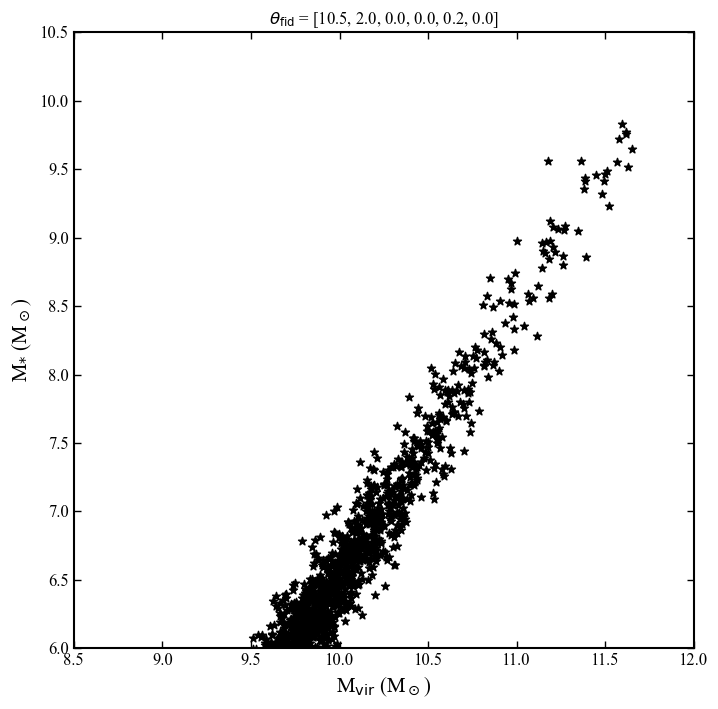

(9900, 1749)


In [5]:
ind = 43
modeldir = "../../mcmc/inference_tests/convergence/mock_1/Nhost_100/"
mock_1_N100 = jsm_models.SAMPLE_SAGA_NEW(fid_theta=fid_theta, meta_path=meta_path, SAGA_ind=ind, Nhost_M=100, savedir=None, savemodel=modeldir, plot=False) 
print(mock_1_N100.lgMh_models.shape)

modeldir = "../../mcmc/inference_tests/convergence/mock_1/Nhost_1000/"
mock_1_N1000 = jsm_models.SAMPLE_SAGA_NEW(fid_theta=fid_theta, meta_path=meta_path, SAGA_ind=ind, Nhost_M=1000, savedir=None, savemodel=modeldir, plot=False)
print(mock_1_N1000.lgMh_models.shape) 

datadir = "../../mcmc/inference_tests/convergence/mock_1/Nhost_10000/"
mock_1_N10000 = jsm_models.SAMPLE_SAGA_NEW(fid_theta=fid_theta, meta_path=meta_path, SAGA_ind=ind, Nhost_M=None, savedir=datadir, savemodel=datadir, plot=True) 
print(mock_1_N10000.lgMh_models.shape) 

selecting the 89th saga index to be the data

selecting the 89  SAGA sample
converting the subhalos to satellites and creating the mock data instance
breaking off the remaining samples and creating the model instance
Only using the first 100 trees for the model
saving the models
(100, 1749)
selecting the 89  SAGA sample
converting the subhalos to satellites and creating the mock data instance
breaking off the remaining samples and creating the model instance
Only using the first 1000 trees for the model
saving the models
(1000, 1749)
selecting the 89  SAGA sample
converting the subhalos to satellites and creating the mock data instance
saving the mock data
breaking off the remaining samples and creating the model instance
saving the models


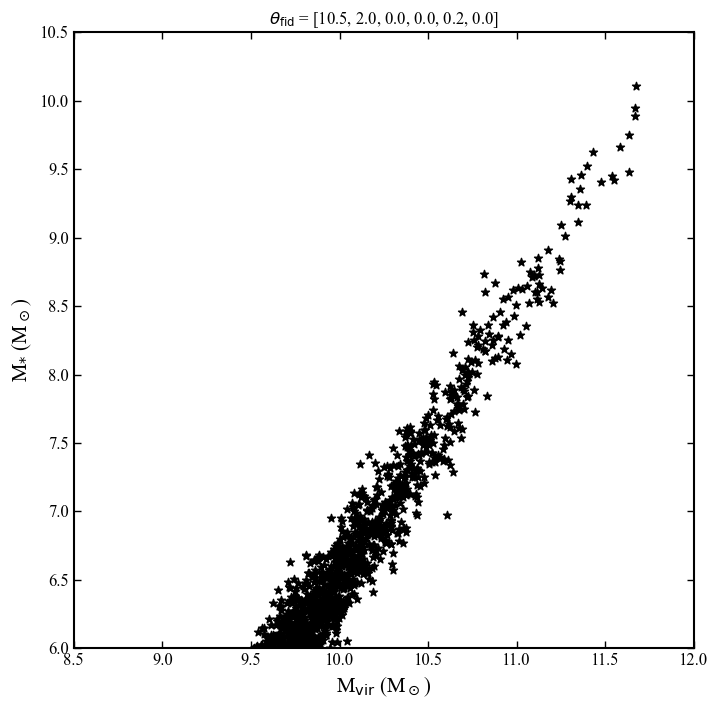

(9900, 1749)


In [6]:
ind = 89
modeldir = "../../mcmc/inference_tests/convergence/mock_2/Nhost_100/"
mock_2_N100 = jsm_models.SAMPLE_SAGA_NEW(fid_theta=fid_theta, meta_path=meta_path, SAGA_ind=ind, Nhost_M=100, savedir=None, savemodel=modeldir, plot=False) 
print(mock_2_N100.lgMh_models.shape)

modeldir = "../../mcmc/inference_tests/convergence/mock_2/Nhost_1000/"
mock_2_N1000 = jsm_models.SAMPLE_SAGA_NEW(fid_theta=fid_theta, meta_path=meta_path, SAGA_ind=ind, Nhost_M=1000, savedir=None, savemodel=modeldir, plot=False)
print(mock_2_N1000.lgMh_models.shape) 

datadir = "../../mcmc/inference_tests/convergence/mock_2/Nhost_10000/"
mock_2_N10000 = jsm_models.SAMPLE_SAGA_NEW(fid_theta=fid_theta, meta_path=meta_path, SAGA_ind=ind, Nhost_M=None, savedir=datadir, savemodel=datadir, plot=True) 
print(mock_2_N10000.lgMh_models.shape) 

selecting the 11th saga index to be the data

selecting the 72  SAGA sample
converting the subhalos to satellites and creating the mock data instance
breaking off the remaining samples and creating the model instance
Only using the first 100 trees for the model
saving the models
(100, 1749)
selecting the 72  SAGA sample
converting the subhalos to satellites and creating the mock data instance
breaking off the remaining samples and creating the model instance
Only using the first 1000 trees for the model
saving the models
(1000, 1749)
selecting the 72  SAGA sample
converting the subhalos to satellites and creating the mock data instance
saving the mock data
breaking off the remaining samples and creating the model instance
saving the models


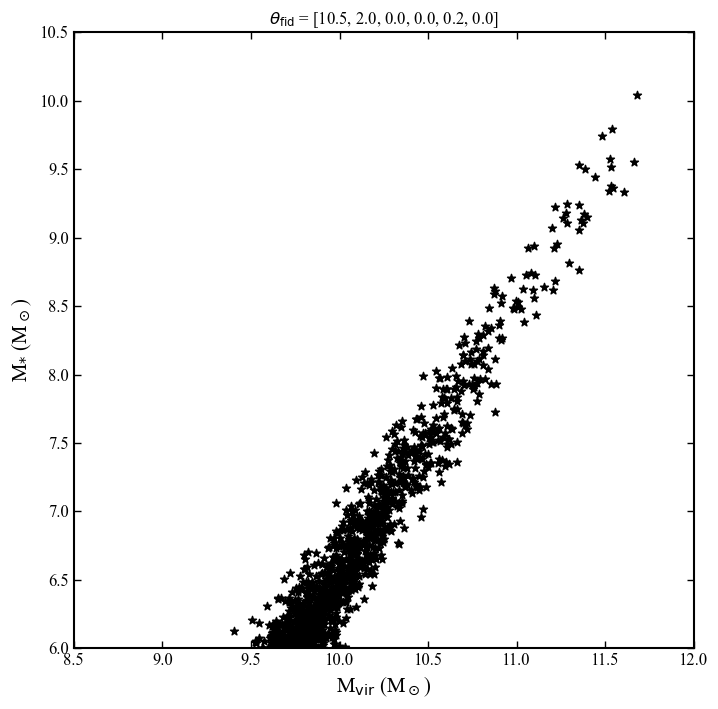

(9900, 1749)


In [36]:
ind = 72
modeldir = "../../mcmc/inference_tests/convergence/mock_3/Nhost_100/"
mock_3_N100 = jsm_models.SAMPLE_SAGA_NEW(fid_theta=fid_theta, meta_path=meta_path, SAGA_ind=ind, Nhost_M=100, savedir=None, savemodel=modeldir, plot=False) 
print(mock_3_N100.lgMh_models.shape)

modeldir = "../../mcmc/inference_tests/convergence/mock_3/Nhost_1000/"
mock_3_N1000 = jsm_models.SAMPLE_SAGA_NEW(fid_theta=fid_theta, meta_path=meta_path, SAGA_ind=ind, Nhost_M=1000, savedir=None, savemodel=modeldir, plot=False)
print(mock_3_N1000.lgMh_models.shape) 

datadir = "../../mcmc/inference_tests/convergence/mock_3/Nhost_10000/"
mock_3_N10000 = jsm_models.SAMPLE_SAGA_NEW(fid_theta=fid_theta, meta_path=meta_path, SAGA_ind=ind, Nhost_M=None, savedir=datadir, savemodel=datadir, plot=True)
print(mock_3_N10000.lgMh_models.shape) 

### now the figure